In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pyro
import torch
import arviz as az

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


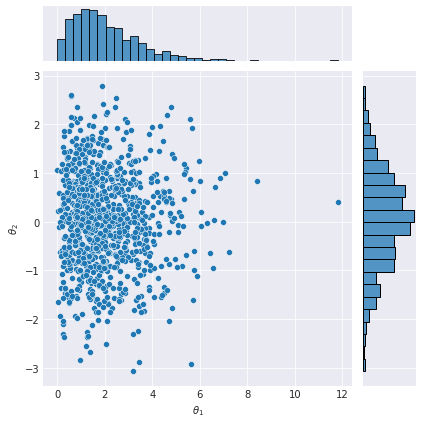

In [4]:
np.random.seed(123)
x = np.random.gamma(2, 1, 1000)
y = np.random.normal(0, 1, 1000)
data = pd.DataFrame(data=np.array([x, y]).T,
                    columns=['$\\theta_1$', '$\\theta_2$'])

sns.jointplot(x='$\\theta_1$', y='$\\theta_2$',
              data=data)

plt.savefig('B04958_03_01.png', dpi=300, figsize=(5.5, 5.5))

# Gaussian inferences

In [5]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40,
                 48.45, 52.34, 55.65, 51.49, 51.86, 63.43,
                 53.00, 56.09, 51.93, 52.31, 52.33, 57.48,
                 57.44, 55.14, 53.93, 54.62, 56.09, 68.58,
                 51.36, 55.47, 50.73, 51.94, 54.95, 50.39,
                 52.91, 51.50, 52.68, 47.72, 49.73, 51.82,
                 54.99, 52.84, 53.19, 54.52, 51.46, 53.73,
                 51.61, 49.81, 52.42, 54.30, 53.84, 53.16])

quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
clean_data = data[(data > lower_b) & (data < upper_b)]

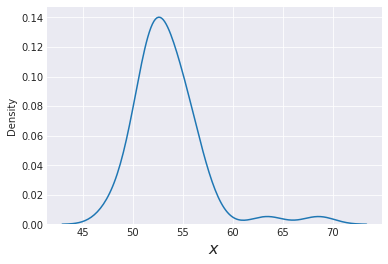

In [6]:
sns.kdeplot(data)
plt.xlabel('$x$', fontsize=16)
plt.savefig('B04958_03_02.png', dpi=300)

Model

$$
\mu \sim {\rm Uniform(l, h)} \\
\sigma \sim {\rm HarfNormal}(\sigma_\sigma) \\
y = {\rm Normal}(\mu, \sigma)
$$

In [7]:
def model_g(data=None):
    mu = pyro.sample("mu", pyro.distributions.Uniform(40, 75))
    sigma = pyro.sample("sigma", pyro.distributions.HalfNormal(10))
    y = pyro.sample("y", pyro.distributions.Normal(mu, sigma), obs=data)

nuts_kernel = pyro.infer.mcmc.NUTS(model_g)
mcmc_run = pyro.infer.mcmc.MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc_run.run(torch.tensor(data))

Sample: 100%|██████████| 1100/1100 [00:08, 129.02it/s, step size=1.14e+00, acc. prob=0.835]


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


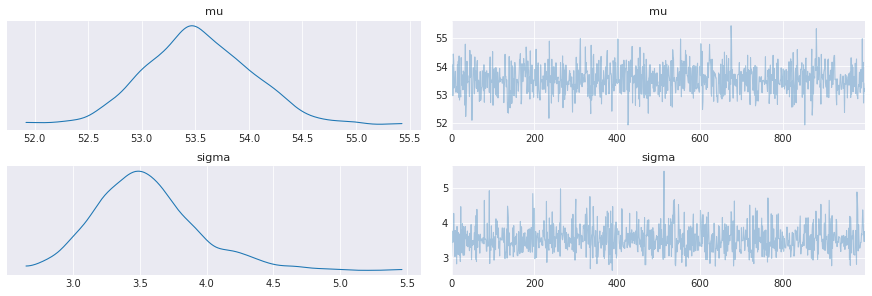

In [8]:
az.plot_trace(mcmc_run)
plt.savefig('B11197_02_01.png')

In [9]:
az.summary(mcmc_run)

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.53,0.50,52.61,54.42,0.02,1.10e-02,1014.0,1014.0,1050.0,807.0,NaN
sigma,3.55,0.38,2.93,4.34,0.01,8.00e-03,1045.0,1025.0,1043.0,762.0,NaN


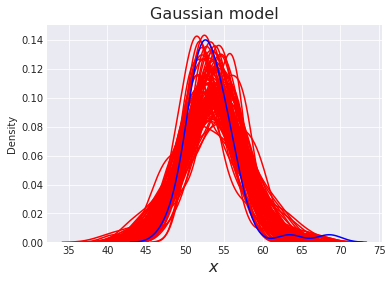

In [10]:
# 予測分布の生成
y_preds = [pyro.infer.Predictive(model_g, mcmc_run.get_samples(len(data)))() for _ in range(100)]
for y_pred in y_preds:
    sns.kdeplot(y_pred['y'], c="r", alpha = 0.1)
sns.kdeplot(data, c="b")
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.savefig('B04958_03_04b.png', dpi=300)

## Gaussian Robust inferences

Now we are going to learn how to make a robust model to outliers, that is a model that do not get too much excited by outliers. For that we are going to use a Student T distribution:

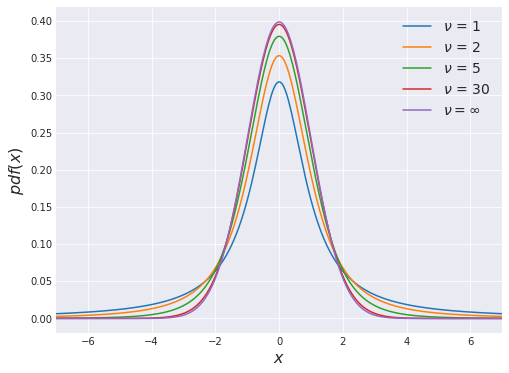

In [11]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdｆ(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values) # \mu = \infinで正規分布
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', fontsize=16, rotation=90)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.savefig('B04958_03_05.png', dpi=300)

Model

$$
\mu \sim {\rm Uniform(l, h)} \\
\sigma \sim {\rm HarfNormal}(\sigma_\sigma) \\
\nu \sim {\rm Exponential}(\lambda) \\
y = {\rm StudentT}(\mu, \sigma, \nu)
$$

In [12]:
def model_t(data=None):
    mu = pyro.sample("mu", pyro.distributions.Uniform(40, 75))
    sigma = pyro.sample("sigma", pyro.distributions.HalfNormal(10))
    nu = pyro.sample("nu", pyro.distributions.Exponential(1/30))
    y = pyro.sample("y", pyro.distributions.StudentT(df=nu, loc=mu, scale=sigma), obs=data)

nuts_kernel_t = pyro.infer.mcmc.NUTS(model_t)
mcmc_run_t = pyro.infer.mcmc.MCMC(nuts_kernel_t, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc_run_t.run(torch.tensor(data))

Sample: 100%|██████████| 1100/1100 [00:23, 47.01it/s, step size=3.32e-01, acc. prob=0.977]


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


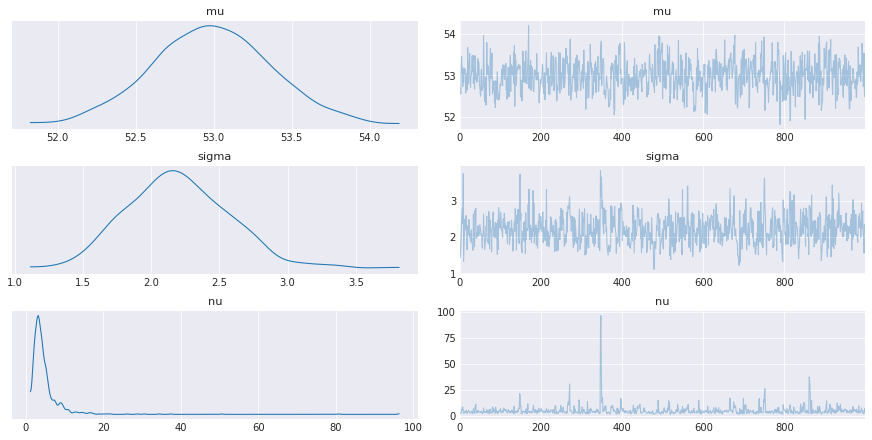

In [13]:
az.plot_trace(mcmc_run_t)
plt.savefig('B04958_03_07.png')

In [14]:
az.summary(mcmc_run_t)

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,52.99,0.38,52.22,53.64,0.02,0.01,479.0,479.0,480.0,432.0,NaN
sigma,2.21,0.40,1.45,2.87,0.02,0.01,469.0,469.0,459.0,538.0,NaN
nu,4.82,5.26,1.16,9.77,0.29,0.21,324.0,324.0,438.0,424.0,NaN


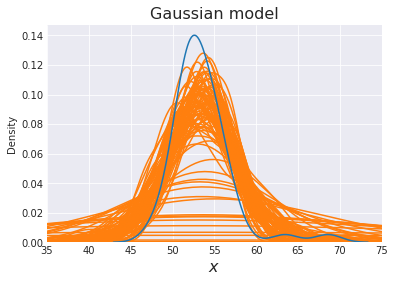

In [15]:
# 予測分布の生成
y_preds = [pyro.infer.Predictive(model_t, mcmc_run.get_samples(len(data)))() for _ in range(100)]

for y_pred in y_preds:
    sns.kdeplot(y_pred['y'], c="C1", alpha = 0.1)
sns.kdeplot(data, c="C0")

plt.xlim(35, 75)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.savefig('B04958_03_07b.png', dpi=300)

# Tips example

In [16]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  


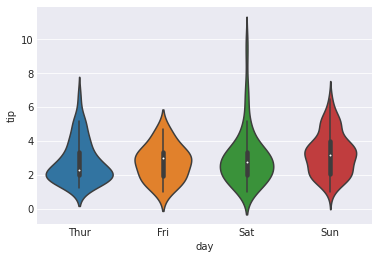

In [17]:
sns.violinplot(x='day', y='tip', data=tips);
plt.savefig('B04958_03_08.png', dpi=300, figsize=(5.5, 5.5))

Model

$$
\boldsymbol{\mu} \sim {\rm Uniform(l, h)} \in {\mathbb R}^4 \\
\boldsymbol{\sigma} \sim {\rm HarfNormal}(\sigma_\sigma)  \in {\mathbb R}^4\\
\boldsymbol{y} = {\rm Normal}(\mu_i, {\sigma}_i)\in {\mathbb R}^4
$$

In [18]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [19]:
def comparing_groups(week_obs, tip_obs):
    with pyro.plate("week", size=len(set(week_obs))):
        means = pyro.sample("means", pyro.distributions.Uniform(0, 10))
        sigmas = pyro.sample("sigmas", pyro.distributions.HalfNormal(10))

    with pyro.plate("tip", size=len(tip_obs)):
        y = pyro.sample("y", pyro.distributions.Normal(means[idx], sigmas[idx]), obs=tip_obs)

In [20]:
nuts_kernel_comparing_groups = pyro.infer.mcmc.NUTS(comparing_groups)
mcmc_run_comparing_groups = pyro.infer.mcmc.MCMC(nuts_kernel_comparing_groups, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc_run_comparing_groups.run(idx, torch.tensor(y))

Warmup:   0%|          | 0/1100 [00:00, ?it/s]/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  import sys
Sample: 100%|██████████| 1100/1100 [00:33, 32.82it/s, step size=2.26e-01, acc. prob=0.948]


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "
/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  


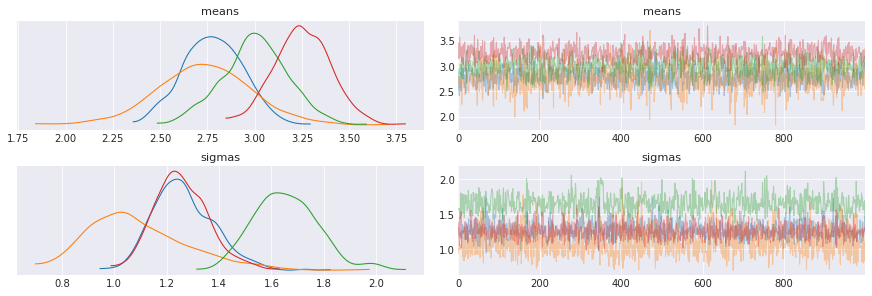

In [21]:
az.plot_trace(mcmc_run_comparing_groups, compact=True)
plt.savefig('B04958_03_09.png', dpi=300, figsize=(5.5, 5.5))

In [22]:
trace_cg = az.convert_to_dataset(mcmc_run_comparing_groups.get_samples(5000))

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/base.py:153: UserWarning: More chains (5000) than draws (4). Passed array should have shape (chains, draws, *shape)
  UserWarning,


**Cohen's d**

$$
\delta=\frac{\mu_1-\mu_2}{\sqrt{\frac{\sigma^2_1+\sigma^2_2}{2}}}
$$

**Prob sup**

$$
{\rm ps} = \Phi\Big(\frac{\delta}{\sqrt{2}}\Big)
$$

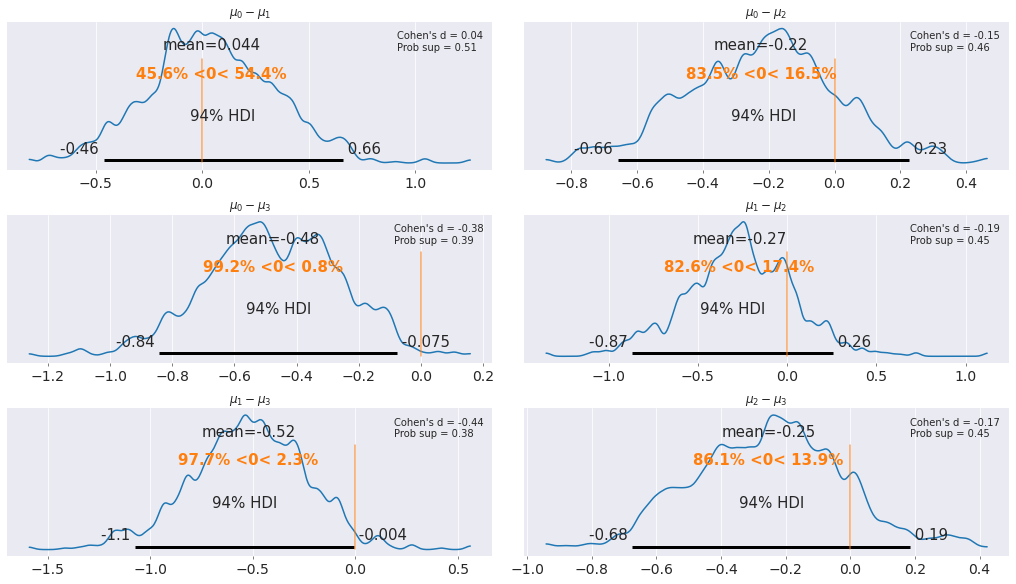

In [23]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['means'][:, i] - trace_cg['means'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['sigmas'][:, i]**2 + trace_cg['sigmas'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {float(d_cohen):.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

# Hierarchical Models

In [24]:
N_samples =  [30, 30, 30]
G_samples =  [13, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []  
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

$$\alpha \sim {\rm HalfCauchy}(\beta_{\alpha})$$
$$\beta \sim {\rm HalfCauchy}(\beta_{\beta})$$
$$\theta \sim {\rm Beta}(\alpha, \beta)$$
$$y \sim {\rm Bern}(\theta)$$

In [25]:
def model_h(group_idx, data):
    alpha = pyro.sample("alpha", pyro.distributions.HalfCauchy(10))
    beta = pyro.sample("beta", pyro.distributions.HalfCauchy(10))

    with pyro.plate("class", size=len(N_samples)):
        theta = pyro.sample("theta", pyro.distributions.Beta(alpha, beta))

    with pyro.plate("data", size=len(data)):
        y = pyro.sample("y", pyro.distributions.Bernoulli(theta[group_idx]), obs=data)

In [26]:
nuts_kernel_h = pyro.infer.mcmc.NUTS(model_h)
mcmc_run_h = pyro.infer.mcmc.MCMC(nuts_kernel_h, num_samples=2000, warmup_steps=100, num_chains=1)
mcmc_run_h.run(group_idx, torch.tensor(data).float())

Sample: 100%|██████████| 2100/2100 [01:31, 22.95it/s, step size=2.47e-01, acc. prob=0.955]


/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


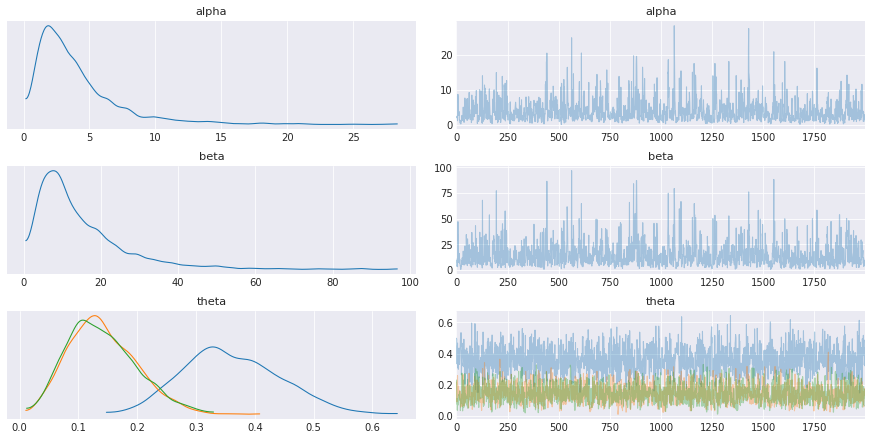

In [27]:
az.plot_trace(mcmc_run_h, compact=True)
plt.savefig('B04958_03_12.png', dpi=300)

/home/kajyuuen/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


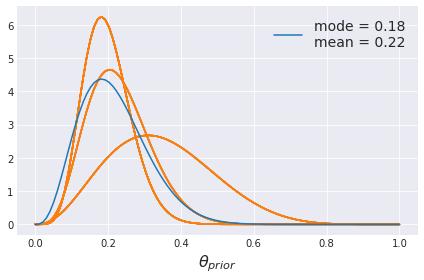

In [28]:
trace_h = mcmc_run_h.get_samples(2000)
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    pdf = stats.beta(trace_h['alpha'][i], trace_h['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

dist = stats.beta(trace_h['alpha'].mean(), trace_h['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_03_13.png', dpi=300, figsize=(5.5, 5.5))